In [42]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
from functools import partial
import sys
from pathlib import Path

import numpy as np
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.optimize import minimize_scalar
import statsmodels.api as sm

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))
    
from src.dgps import *

seed = 0
n=100
n_int=100
int_samples=10**5
noise=1.0
front_door = False
int_scale = 4
quantiles = torch.linspace(0,1,100)[:,None]

""" Setting method """
if front_door:
    method = "ATT_frontdoor_doB_b"
else:
    method = "CATE_backdoor_doD_bfixed"

""" Drawing data """
A,B,C,D,E,Y,vals,EYdoX = Simulation(n,n_int, 
           mc_samples_EYdoX = int_samples, 
           seed = seed, 
           draw_EYdoX = True, 
           noise = noise,
           method = method, 
           int_min=-int_scale*noise, 
           int_max = int_scale*noise
            )

""" Variable definitions """
A = B
V = C
if front_door:
    W = B
    doA = vals
    doW = torch.zeros((1,1))     
else:
    W = D
    doA = torch.zeros((1,1))
    doW = vals
    
""" Instantiating + training model """
l = C.numpy()
a = D[:,0].numpy()
y = Y[:,0].numpy()

# Ensure l, a, y are numpy arrays
l = np.asarray(l)
a = np.asarray(a)
y = np.asarray(y)

n, p = l.shape
a_min = -2
a_max = 2
a_vals = np.linspace(a_min, a_max, num=100)
num_a_vals = len(a_vals)

# Set up evaluation points & matrices for predictions
# Create la_new by stacking the original data and new data for predictions
l_repeated = np.repeat(l, num_a_vals, axis=0)
a_repeated = np.tile(a_vals, n)
la_new_extra = np.hstack([l_repeated, a_repeated.reshape(-1, 1)])
la_new = np.vstack([np.hstack([l, a.reshape(-1, 1)]), la_new_extra])
l_new = la_new[:, :-1]

# Fit Super Learner (other methods could be used here instead)
base_models = [
    #('lr', LinearRegression()),
    #('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor(n_estimators=100)),
    #('gb', GradientBoostingRegressor(n_estimators=100)),
    #('ridge', Ridge()),
    #('lasso', Lasso())
]

# pimod: model for a given l
pimod = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
pimod.fit(l, a)
pimod_vals = pimod.predict(l_new)
sq_res = (a - pimod.predict(l)) ** 2

# pi2mod: model for squared residuals
pi2mod = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
pi2mod.fit(l, sq_res)
pi2mod_vals = np.abs(pi2mod.predict(l_new))

# mumod: model for y given l and a using Random Forest Regressor
l_a = np.hstack([l, a.reshape(-1, 1)])
# Use Random Forest Regressor for muhat
mumod = RandomForestRegressor(n_estimators=100)
mumod.fit(l_a, y)
# Predict muhat_vals for both original and new data
la_new = np.vstack([np.hstack([l, a.reshape(-1, 1)]), la_new_extra])
muhat_vals = mumod.predict(la_new)

# Construct estimated pi/varpi and mu/m values
a_std = (la_new[:, -1] - pimod_vals) / np.sqrt(pi2mod_vals)
a_std_n = a_std[:n]

# Nadaraya-Watson estimation for pihat
def nadaraya_watson_density(z_vals, x_vals, h):
    n = len(x_vals)
    K = norm.pdf((z_vals[:, np.newaxis] - x_vals[np.newaxis, :]) / h)
    densities = np.sum(K, axis=1) / (n * h)
    return densities

h_pihat = 0.106 * np.std(a_std_n) * n ** (-1/5)
pihat_vals = nadaraya_watson_density(a_std, a_std_n, h_pihat)
pihat = pihat_vals[:n]
pihat_mat = pihat_vals[n:].reshape(n, num_a_vals)

# varpihat estimation using local linear regression
varpihat_mean = np.mean(pihat_mat, axis=0)
kr_varpihat = KernelReg(endog=varpihat_mean, exog=a_vals, var_type='c', reg_type='ll')
varpihat, _ = kr_varpihat.fit(a)
varpihat[varpihat==0] = 1e-3
varpihat[np.isinf(varpihat)]=1
varpihat_mat = np.tile(varpihat_mean, (n, 1))

# muhat and mhat estimation using local linear regression
muhat = muhat_vals[:n]
muhat_mat = muhat_vals[n:].reshape(n, num_a_vals)
mhat_mean = np.mean(muhat_mat, axis=0)
kr_mhat = KernelReg(endog=mhat_mean, exog=a_vals, var_type='c', reg_type='ll')
mhat, _ = kr_mhat.fit(a)
mhat_mat = np.tile(mhat_mean, (n, 1))

# Form adjusted/pseudo outcome xi
pseudo_out = (y - muhat) / (pihat / varpihat) + mhat

# Leave-one-out cross-validation to select bandwidth
def kern(x):
    return norm.pdf(x)

def w_fn(bw):
    w_avals = []
    for a_val in a_vals:
        a_std = (a - a_val) / bw
        kern_std = kern(a_std) / bw
        numerator = np.mean(a_std ** 2 * kern_std) * (kern(0) / bw)
        denominator = np.mean(kern_std) * np.mean(a_std ** 2 * kern_std) - (np.mean(a_std * kern_std)) ** 2
        w_val = numerator / denominator
        w_avals.append(w_val)
    return np.array(w_avals) / n

def hatvals(bw):
    w_avals = w_fn(bw)
    hat_vals = np.interp(a, a_vals, w_avals)
    return hat_vals

def cts_eff(out, bw):
    kr = KernelReg(endog=out, exog=a, var_type='c', reg_type='ll', bw=[bw])
    y_pred, _ = kr.fit(a)
    return y_pred

def cross_val_func(h):
    hats = hatvals(h)
    y_pred = cts_eff(pseudo_out, h)
    residuals = (pseudo_out - y_pred) / (1 - hats)
    return np.mean(residuals ** 2)

res = minimize_scalar(cross_val_func, bounds=(0.01, 50), method='bounded', options={'xatol': 0.01})
h_opt = res.x

# Estimate effect curve with optimal bandwidth
kr_est = KernelReg(endog=pseudo_out, exog=a, var_type='c', reg_type='ll', bw=[h_opt])
est, _ = kr_est.fit(a_vals)

# Estimate sandwich-style pointwise confidence band
se_list = []
for idx, a_val in enumerate(a_vals):
    a_std = (a - a_val) / h_opt
    kern_std = kern(a_std) / h_opt**2  # kern_std = (kern(a_std)/h_opt)/h_opt

    # Weighted linear regression of pseudo_out ~ a_std
    X = np.vstack([np.ones_like(a_std), a_std]).T
    weights = kern_std

    X_filtered = X
    pseudo_out_filtered = pseudo_out
    weights_filtered = weights
    a_std_filtered = a_std

    # Fit the weighted least squares model using statsmodels
    model = sm.WLS(pseudo_out_filtered, X_filtered, weights=weights_filtered)
    results = model.fit()
    beta = results.params

    # Compute Dh
    mean_kern_std = np.mean(weights_filtered)
    mean_kern_std_a_std = np.mean(weights_filtered * a_std_filtered)
    mean_kern_std_a_std2 = np.mean(weights_filtered * a_std_filtered ** 2)
    Dh = np.array([[mean_kern_std, mean_kern_std_a_std],
                   [mean_kern_std_a_std, mean_kern_std_a_std2]])

    # Compute kern_mat and g2
    a_vals_diff = (a_vals - a_val) / h_opt
    kern_mat = kern(a_vals_diff) / h_opt
    kern_mat = np.tile(kern_mat, (n, 1))
    g2 = np.tile(a_vals_diff, (n, 1))

    # Compute intfn1_mat and intfn2_mat
    intfn1_mat = kern_mat * (muhat_mat - mhat_mat) * varpihat_mat
    intfn2_mat = g2 * kern_mat * (muhat_mat - mhat_mat) * varpihat_mat

    # Compute integrals int1 and int2 for each observation
    # Using the trapezoidal rule
    delta_a_vals = np.diff(a_vals)
    delta_a_vals = np.tile(delta_a_vals, (n, 1))
    int1 = np.sum(((intfn1_mat[:, :-1] + intfn1_mat[:, 1:]) / 2) * delta_a_vals, axis=1)
    int2 = np.sum(((intfn2_mat[:, :-1] + intfn2_mat[:, 1:]) / 2) * delta_a_vals, axis=1)

    # Compute residuals
    residuals = pseudo_out - X @ beta

    # Prepare matrix for covariance calculation
    temp_matrix = np.vstack([
        weights * residuals + int1,
        a_std * weights * residuals + int2
    ])

    # Solve Dh inverse
    Dh_inv = np.linalg.inv(Dh)

    # Multiply Dh_inv by temp_matrix
    matrix = Dh_inv @ temp_matrix

    # Compute covariance matrix sigma
    sigma = np.cov(matrix)

    # Append standard error
    se_list.append(np.sqrt(sigma[0, 0]))

# Convert se_list to array
se_array = np.array(se_list)


mu = torch.tensor(est).view(len(est),1).float()
var = torch.tensor(se_array**2/n).view(len(se_array),1).float()

""" Compute out of sample metrics """
z_quantiles = Normal(0, 1).icdf(1-(1-quantiles)/2)
posterior_fraction = ((EYdoX - mu).abs() <= var**0.5 @ z_quantiles.T).float()
rmse = ((EYdoX - mu)**2).mean()**0.5

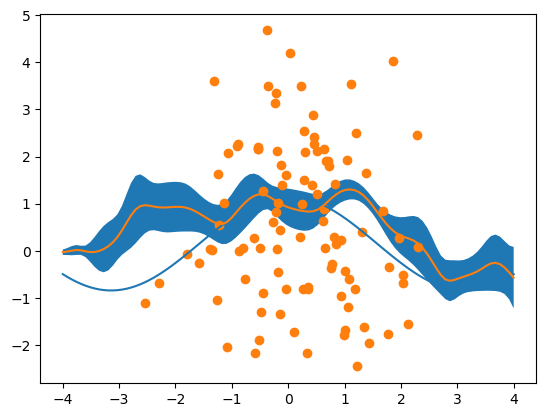

In [46]:
plt.plot(vals, EYdoX)
plt.plot(vals, mu)
plt.fill_between(vals[:,0], mu[:,0]-2*var[:,0]**0.5,mu[:,0]+2*var[:,0]**0.5)
plt.scatter(a,y)